In [1]:
# load libraries
#%matplotlib inline
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import BoundaryNorm

#import seaborn as sns
#import time
#import os
#from pysal.esda.mapclassify import Quantiles, Equal_Interval

# List of state ids
states = ['01', '03', '04', '05', '06', '08', '09', '10', '11', '12', '13', '14', '16', '17', '18', '19', '20', 
         '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', 
         '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', 
          '54', '55', '56']

# Dictionary of state names and ids
states_dict = {'Alabama':'01', 'Arizona':'03', 'Arkansas':'05', 'California':'06', 'Colorado':'08', 
              'Connecticut':'09', 'Delaware':'10', 'District of Columbia':'11', 'Florida':'12',
              'Georgia':'13', 'Idaho':'16', 'Illinois':'17', 'Indiana':'18', 'Iowa':'19', 'Kansas':'20',
              'Kentucky':'21', 'Louisiana':'22', 'Maine':'23', 'Maryland':'24', 'Massachusetts':'25',
              'Michigan':'26', 'Minnesota':'27', 'Mississippi':'28', 'Missouri':'29', 'Montana':'30',
              'Nebraska':'31', 'Nevada':'32', 'New Hampshire':'33', 'New Jersey':'34', 'New Mexico':'35',
              'New York':'36', 'North Carolina':'37', 'North Dakota':'38', 'Ohio':'39', 'Oklahoma':'40',
              'Oregon':'41', 'Pennsylvania':'42', 'Rhode Island':'44', 'South Carolina':'45', 
              'South Dakota':'46', 'Tennessee':'47', 'Texas':'48', 'Utah':'49', 'Vermont':'50',
              'Virginia':'51', 'Washington':'53', 'West Virginia':'54', 'Wisconsin':'55', 'Wyoming':'56'}

In [2]:
def read_clean_merge_data(geo_fp, pop_fp, covid_fp):
    
# Step 1: create and clean geopandas dataframe with data from Washington 
    # Load a geo json file into the map/geo dataframe using the geopandas.read_file command
    map_df = gpd.read_file(geo_fp )
    
    # Create a data frame with geo data just from Washington
    geo_df=map_df[map_df['STATE']==states_dict['Washington']]

    # We only need three columns: id, NAME (county name), and the geometry data
    geo_df = geo_df[['id','NAME','geometry']]

    # Rename columns for clarity
    geo_df = geo_df.rename(index=str, columns={'NAME':'county'})
    
    #print(geo_df)
    #geo_df.head()

# Step 2: create and clean the population data
    # Load csv file with population data
    population_df=pd.read_csv(pop_fp, dtype={'FIPS':'str'})
    
    # Rename the columns 
    population_df = population_df.rename(index=str, 
                                         columns={'FIPS':'fips', 'CTYNAME':'county', 'Population':'population'})

    # Trim unnecessary columns
    population_df = population_df[['fips','population']]
    #print(len(population_df))
    #population_df.head()

# Step 3: create and clean the case and death data
    # Read in case and deaths data from NYT csv file
    cases_and_deaths_df=pd.read_csv(covid_fp, dtype={'fips':'str'})
    #print(len(cases_and_deaths_df))

    # Remove any entries with no fips data
    cases_and_deaths_df=cases_and_deaths_df.dropna(subset=['fips'])

    # Remove all entries except for ones from Washington
    cases_and_deaths_df=cases_and_deaths_df[cases_and_deaths_df['state']=='Washington']

    # We only want 4 columns: date, fips, cases, deaths so remove the rest
    cases_and_deaths_df = cases_and_deaths_df[['date','fips','cases','deaths']]
    

# Step 4: Create a list of the dates for which we have case/death data
    dates = cases_and_deaths_df['date'].tolist()

    # Remove any duplicate dates
    dates = list(dict.fromkeys(dates))

# Step 5: Create a new data frame that contains county population, raw and per capita case and death data 
# for each date in dates


    # df is a temporary dataframe with case data for some specific date, in this case the first date in dates
    df = cases_and_deaths_df[cases_and_deaths_df['date']==dates[0]]

    df = df[['fips','cases', 'deaths']]

    # Create new data frame by merging df and population_df <- look at the pandas.merge command to understand
    # the syntax. Its not obvious
    pop_and_data = population_df.merge(df, on='fips', how='left')

    # Rename the case column to the date and '_raw'
    pop_and_data = pop_and_data.rename(index=str, columns={'cases':'cases_'+dates[0],'deaths':'deaths_'+dates[0] })

    # Set any missing data to zero
    pop_and_data.fillna(0, inplace=True)

    # Now we loop over the dates, appending the case data to the pop_and_data dataframe
    for i in range(1,len(dates)):
        df = cases_and_deaths_df[cases_and_deaths_df['date']==dates[i]]
        df = df[['fips','cases', 'deaths']]
        pop_and_data = pop_and_data.merge(df, on='fips', how='left')
        pop_and_data = pop_and_data.rename(index=str, columns={'cases':'cases_'+dates[i],'deaths':'deaths_'+dates[i] })
        pop_and_data['cases_'+dates[i]].fillna(0, inplace=True)
        pop_and_data['deaths_'+dates[i]].fillna(0, inplace=True)
    
    
    #pop_and_data
# Finally, we merge the geo dataframe and the pop_and_data dataframe
    geo_pop_and_data_df = geo_df.set_index('id').join(pop_and_data.set_index('fips'))
    
    #geo_pop_and_data_df.sort_values(by=['id'])

    
    return geo_pop_and_data_df, dates

In [3]:
#data_dir = '/Users/dpcook/Desktop/Repos/NYT-covid-19-data'

geo_fp = '../data_geographic/geojson-counties-fips.json'
pop_fp = '../data_population/washington-census-data.csv'
covid_fp =  '../NYT-covid-19-data/us-counties.csv'

geo_pop_and_data_df, dates = read_clean_merge_data(geo_fp, pop_fp, covid_fp)
geo_pop_and_data_df.head()

,county,geometry,population,cases_2020-01-21,deaths_2020-01-21,cases_2020-01-22,deaths_2020-01-22,cases_2020-01-23,deaths_2020-01-23,cases_2020-01-24,...,cases_2020-06-07,deaths_2020-06-07,cases_2020-06-08,deaths_2020-06-08,cases_2020-06-09,deaths_2020-06-09,cases_2020-06-10,deaths_2020-06-10,cases_2020-06-11,deaths_2020-06-11
id,,,,,,,,,,,,,,,,,,,,,
53013,Columbia,"POLYGON ((-118.22893 46.59361, -118.22447 46.5...",3985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
53021,Franklin,"POLYGON ((-119.08162 46.73802, -118.20981 46.7...",95222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,859.0,21.0,943.0,21.0,956.0,22.0,979.0,22.0,1008.0,25.0
53041,Lewis,"POLYGON ((-121.52356 46.38822, -122.24101 46.3...",80707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.0,3.0,37.0,3.0,37.0,3.0,37.0,3.0,37.0,3.0
53045,Mason,"POLYGON ((-122.90566 47.15561, -122.93672 47.1...",66768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.0,1.0,38.0,1.0,39.0,1.0,39.0,1.0,39.0,1.0
53065,Stevens,"POLYGON ((-118.19689 49.00009, -117.42954 48.9...",45723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,1.0,13.0,1.0,13.0,1.0,14.0,1.0,15.0,1.0


In [4]:
geo_pop_and_data_df.sort_values(by='id', inplace=True)
geo_pop_and_data_df.head()


,county,geometry,population,cases_2020-01-21,deaths_2020-01-21,cases_2020-01-22,deaths_2020-01-22,cases_2020-01-23,deaths_2020-01-23,cases_2020-01-24,...,cases_2020-06-07,deaths_2020-06-07,cases_2020-06-08,deaths_2020-06-08,cases_2020-06-09,deaths_2020-06-09,cases_2020-06-10,deaths_2020-06-10,cases_2020-06-11,deaths_2020-06-11
id,,,,,,,,,,,,,,,,,,,,,
53001,Adams,"POLYGON ((-119.13607 46.91222, -118.98255 46.9...",19983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,79.0,0.0,79.0,0.0,80.0,0.0,87.0,0.0,89.0,0.0
53003,Asotin,"POLYGON ((-117.03981 46.42542, -117.04691 46.3...",22582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,2.0,19.0,2.0,19.0,2.0,20.0,2.0,20.0,2.0
53005,Benton,"POLYGON ((-119.86813 45.83596, -119.86626 46.0...",204390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1100.0,69.0,1153.0,69.0,1165.0,69.0,1185.0,71.0,1221.0,71.0
53007,Chelan,"POLYGON ((-121.11901 47.77993, -121.07071 47.8...",77200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,265.0,7.0,266.0,7.0,268.0,7.0,272.0,7.0,272.0,7.0
53009,Clallam,"POLYGON ((-123.13142 48.15274, -123.12482 48.1...",77331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,0.0,27.0,0.0,27.0,0.0,29.0,0.0,29.0,0.0


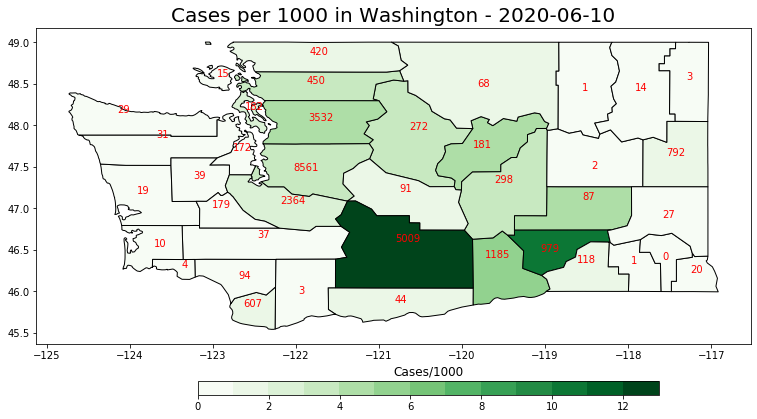

In [5]:
import matplotlib.colors as mcolors
# Note in the following 'ax' is the figure axes and 'cbax' is the colorbar axes

# Choose date and data (cases or deaths)
date = '2020-06-10'
data = 'cases'
dtype = 'per 1000'

if dtype == 'raw':
    geo_pop_and_data_df['plot'] = geo_pop_and_data_df[data+'_'+date]
    # set the range for the choropleth
    vmin, vmax = 0, 8000

else:
    geo_pop_and_data_df['plot'] = 1000*geo_pop_and_data_df[data+'_'+date]/geo_pop_and_data_df['population']
    # set the range for the choropleth
    vmin, vmax = 0, 13



# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12.8, 9.6))

# specify the name of the colormap
#cmap = 'Purples'
cmap = 'RdPu'
#cmap = 'RdBu'
cmap = 'Greens'

# create map
#geo_pop_and_data_df.plot(column='plot', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='1.0', 
#                         vmin=vmin, vmax=vmax, scheme="User_Defined", legend=True, 
#                         classification_kwds=dict(bins=[1,2,3,4,5,6,7,8,9,10,11,12]))

bounds = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)

geo_pop_and_data_df.plot(column='plot', cmap=cmap, norm=norm, ax=ax, edgecolor='0.0', 
                         vmin=vmin, vmax=vmax)

# remove the axis
#ax.axis('off')

# add a title
ax.set_title(data.capitalize()+' '+dtype+' in Washington - '+date, fontdict={'fontsize': '20', 'fontweight' : '3'})

# add colorbar axes to the figure, here, need trial-and-error to get [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.3, 0.2, 0.5, 0.02])   
cbax.set_title('Cases/1000')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
fig.colorbar(sm, cax=cbax, orientation='horizontal')

# Add Labels for names of counties
geo_pop_and_data_df['coords'] = geo_pop_and_data_df['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_pop_and_data_df['coords'] = [coords[0] for coords in geo_pop_and_data_df['coords']]


#ax.annotate('King',xy=(-121.87, 47.43), xycoords='data')

for idx, row in geo_pop_and_data_df.iterrows():
    #s=row['county']+str(row['cases_2020-05-25'])
    xy=row['coords']
    #print(s, xy)
    ax.annotate(s=str(int(row['cases_'+date])), xy=row['coords'],
                horizontalalignment='center', verticalalignment='bottom',color='red')

    
# this will save the figure as a high-res png. you can also save as svg
fig.savefig(data+'_'+date+'.png', dpi=100, bbox_inches='tight')

plt.show()

In [6]:
# Note in the following 'ax' is the figure axes and 'cbax' is the colorbar axes

# Choose date and data (cases or deaths)
#date = '2020-05-21'
data = 'cases'
dtype = 'per 1000'

# specify the name of the colormap
cmap = 'Purples'
cmap = 'RdPu'
cmap = 'Greens'

# save all the maps in the charts folder
output_path = './Maps/'


for date in dates:
    print(date, end=' ')

    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(12.8, 9.6))

    if dtype == 'raw':
        geo_pop_and_data_df['plot'] = geo_pop_and_data_df[data+'_'+date]
        # set the range for the choropleth
        vmin, vmax = 0, 8000

    else:
        geo_pop_and_data_df['plot'] = 1000*geo_pop_and_data_df[data+'_'+date]/geo_pop_and_data_df['population']
        # set the range for the choropleth
        vmin, vmax = 0, 13


# create map
#geo_pop_and_data_df.plot(column='plot', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='1.0', 
#                         vmin=vmin, vmax=vmax, scheme="User_Defined", legend=True, 
#                         classification_kwds=dict(bins=[1,2,3,4,5,6,7,8,9,10,11,12]))

    bounds = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)

    geo_pop_and_data_df.plot(column='plot', cmap=cmap, norm=norm, ax=ax, edgecolor='0.0', 
                         vmin=vmin, vmax=vmax)

# remove the axis
#ax.axis('off')

    # add a title
    ax.set_title(data.capitalize()+' '+dtype+' in Washington - '+date, 
                 fontdict={'fontsize': '20', 'fontweight' : '3'})

    # add colorbar axes to the figure, here, need trial-and-error to get [l,b,w,h] right
    # l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
    cbax = fig.add_axes([0.3, 0.2, 0.5, 0.02])   
    cbax.set_title('Cas density (Cases per 1000 population')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    fig.colorbar(sm, cax=cbax, orientation='horizontal')

    # Add Labels for names of counties
    geo_pop_and_data_df['coords'] = geo_pop_and_data_df['geometry'].apply(lambda x: x.representative_point().coords[:])
    geo_pop_and_data_df['coords'] = [coords[0] for coords in geo_pop_and_data_df['coords']]

    for idx, row in geo_pop_and_data_df.iterrows():
        #s=row['county']+str(row['cases_2020-05-25'])
        xy=row['coords']
        #print(s, xy)
        ax.annotate(s=str(int(row['cases_'+date])), xy=row['coords'],
                horizontalalignment='center', verticalalignment='bottom',color='red')

    # this will save the figure as a high-res png. you can also save as svg
    fig.savefig(output_path+data+'_'+date+'.png', dpi=100, bbox_inches='tight')
    plt.close()

    #plt.show()

2020-01-21 2020-01-22 2020-01-23 2020-01-24 2020-01-25 2020-01-26 2020-01-27 2020-01-28 2020-01-29 2020-01-30 2020-01-31 2020-02-01 2020-02-02 2020-02-03 2020-02-04 2020-02-05 2020-02-06 2020-02-07 2020-02-08 2020-02-09 2020-02-10 2020-02-11 2020-02-12 2020-02-13 2020-02-14 2020-02-15 2020-02-16 2020-02-17 2020-02-18 2020-02-19 2020-02-20 2020-02-21 2020-02-22 2020-02-23 2020-02-24 2020-02-25 2020-02-26 2020-02-27 2020-02-28 2020-02-29 2020-03-01 2020-03-02 2020-03-03 2020-03-04 2020-03-05 2020-03-06 2020-03-07 2020-03-08 2020-03-09 2020-03-10 2020-03-11 2020-03-12 2020-03-13 2020-03-14 2020-03-15 2020-03-16 2020-03-17 2020-03-18 2020-03-19 2020-03-20 2020-03-21 2020-03-22 2020-03-23 2020-03-24 2020-03-25 2020-03-26 2020-03-27 2020-03-28 2020-03-29 2020-03-30 2020-03-31 2020-04-01 2020-04-02 2020-04-03 2020-04-04 2020-04-05 2020-04-06 2020-04-07 2020-04-08 2020-04-09 2020-04-10 2020-04-11 2020-04-12 2020-04-13 2020-04-14 2020-04-15 2020-04-16 2020-04-17 2020-04-18 2020-04-19 2020-04-20

In [7]:
# Add Labels for names of counties
geo_pop_and_data_df['coords'] = geo_pop_and_data_df['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_pop_and_data_df['coords'] = [coords[0] for coords in geo_pop_and_data_df['coords']]

for idx, row in geo_pop_and_data_df.iterrows():
    s=row['county']
    xy=row['coords']
    print(s, xy)
    #plt.annotate(s=row['county'], xy=row['coords'],horizontalalignment='center')

geo_pop_and_data_df['coords']

Adams (-118.4702608508417, 47.087663500000005)
Asotin (-117.18091439615607, 46.200604)
Benton (-119.56721076251907, 46.383707)
Chelan (-120.52649489004332, 47.92873)
Clallam (-124.0731770089659, 48.129505)
Clark (-122.51495916011325, 45.795291500000005)
Columbia (-117.92597728161297, 46.3165415)
Cowlitz (-122.62054738374178, 46.1281375)
Douglas (-119.75495880617872, 47.7052765)
Ferry (-118.51744320221573, 48.394893999999994)
Franklin (-118.94320858470127, 46.4517395)
Garfield (-117.55280224917557, 46.360895)
Grant (-119.49236660996324, 47.290881999999996)
Grays Harbor (-123.84229111763986, 47.160413500000004)
Island (-122.49885300179592, 48.164252000000005)
Jefferson (-123.60870333122693, 47.827674)
King (-121.8791041866262, 47.432137499999996)
Kitsap (-122.64703949556501, 47.671798499999994)
Kittitas (-120.67356580477434, 47.184141499999996)
Klickitat (-120.73833056159393, 45.847091000000006)
Lewis (-122.3836651300322, 46.6229515)
Lincoln (-118.40033186961588, 47.460372500000005)
Maso

id
53001     (-118.4702608508417, 47.087663500000005)
53003             (-117.18091439615607, 46.200604)
53005             (-119.56721076251907, 46.383707)
53007              (-120.52649489004332, 47.92873)
53009              (-124.0731770089659, 48.129505)
53011    (-122.51495916011325, 45.795291500000005)
53013            (-117.92597728161297, 46.3165415)
53015            (-122.62054738374178, 46.1281375)
53017            (-119.75495880617872, 47.7052765)
53019    (-118.51744320221573, 48.394893999999994)
53021            (-118.94320858470127, 46.4517395)
53023             (-117.55280224917557, 46.360895)
53025    (-119.49236660996324, 47.290881999999996)
53027    (-123.84229111763986, 47.160413500000004)
53029    (-122.49885300179592, 48.164252000000005)
53031             (-123.60870333122693, 47.827674)
53033     (-121.8791041866262, 47.432137499999996)
53035    (-122.64703949556501, 47.671798499999994)
53037    (-120.67356580477434, 47.184141499999996)
53039    (-120.7383305615939

In [14]:
geo_pop_and_data_df[['county','plot','cases_2020-06-03','deaths_2020-06-03']].sort_values('plot')

,county,plot,cases_2020-06-03,deaths_2020-06-03
id,,,,
53023,Garfield,0.000000,0.0,0.0
53019,Ferry,0.131113,1.0,0.0
53043,Lincoln,0.182832,2.0,0.0
53051,Pend Oreille,0.218595,3.0,0.0
53027,Grays Harbor,0.239805,18.0,0.0
53013,Columbia,0.250941,1.0,0.0
53065,Stevens,0.284321,13.0,1.0
53059,Skamania,0.331044,4.0,0.0
53009,Clallam,0.349148,27.0,0.0


In [9]:
# Create colorbar as a legend, colorbar will be created by ...
#fig = ax.get_figure()
# add colorbar axes to the figure, here, need trial-and-error to get [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
#cbax = fig.add_axes([0.88, 0.28, 0.03, 0.42])   
#cbax.set_title('Cases')
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
#sm._A = []
#fig.colorbar(sm, cax=cbax)
#fig.colorbar(ax.collections[0],ax=ax)
